# Example notebook 2: generate a color image

This notebook walks through generating a color image. The process is essentially running the previous notebook for each filter, but taking care to hold certain properties constant e.g. subhalo population, location within the FOV, etc.

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from hydra import initialize, compose
import astropy.cosmology as astropy_cosmo
from pyHalo.preset_models import CDM
from pprint import pprint

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

# enable use of local modules
repo_dir  = config.machine.repo_dir
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

from mejiro.lenses.lens import Lens
from mejiro.plots import plot
from mejiro.helpers import pyhalo, pandeia_input, color
from mejiro.utils import util

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

# Load a sample strong lens from the survey simulation

Here, we won't bother with setting up a strong lens from scratch. We've prepared a sample strong lens from the survey simulation. It has the appropriate magnitudes for each filter for source and lens, but all other parameters are the same.

In [2]:
f106_dict = util.unpickle(os.path.join(repo_dir, 'examples', '02_files', 'lens_dict_00000006_f106'))
f129_dict = util.unpickle(os.path.join(repo_dir, 'examples', '02_files', 'lens_dict_00000006_f129'))
f184_dict = util.unpickle(os.path.join(repo_dir, 'examples', '02_files', 'lens_dict_00000006_f184'))

f106_lens = f106_dict['lens']
f129_lens = f129_dict['lens']
f184_lens = f184_dict['lens']

Here are its parameters, where the magnitudes are for the F106 band.

In [3]:
pprint(f106_lens.lens_model_list[:3])
pprint(f106_lens.kwargs_lens[:3])
pprint(f106_lens.lens_light_model_list)
pprint(f106_lens.kwargs_lens_light)
pprint(f106_lens.source_model_list)
pprint(f106_lens.kwargs_source)

['EPL', 'SHEAR', 'CONVERGENCE']
[{'center_x': -0.1775294316112599,
  'center_y': -0.0037359973581077553,
  'e1': -0.23865610012322203,
  'e2': 0.1102364105825075,
  'gamma': 2,
  'theta_E': 1.3426264641545231},
 {'dec_0': 0,
  'gamma1': 0.0016459259386161272,
  'gamma2': 0.0024730631565065644,
  'ra_0': 0},
 {'dec_0': 0, 'kappa': -0.021163892066223957, 'ra_0': 0}]
['SERSIC_ELLIPSE']
[{'R_sersic': 0.20470391829392354,
  'center_x': -0.1775294316112599,
  'center_y': -0.0037359973581077553,
  'e1': -0.028164541371324858,
  'e2': 0.011015578615197256,
  'magnitude': 19.211774836860958,
  'n_sersic': 1.0}]
['SERSIC_ELLIPSE']
[{'R_sersic': 0.338794254095208,
  'center_x': 0.36839746284401154,
  'center_y': -0.0178887523739449,
  'e1': -0.02548823147717247,
  'e2': 0.10090171468850867,
  'magnitude': 21.99159234723656,
  'n_sersic': 1.0}]


# Generate synthetic RGB image

Note that the `color.get_rgb` method is simply a wrapper for [`astropy.visualization.make_lupton_rgb`](https://docs.astropy.org/en/stable/api/astropy.visualization.make_lupton_rgb.html), so the arguments `minimum`, `stretch`, and `Q` are described in its documentation.

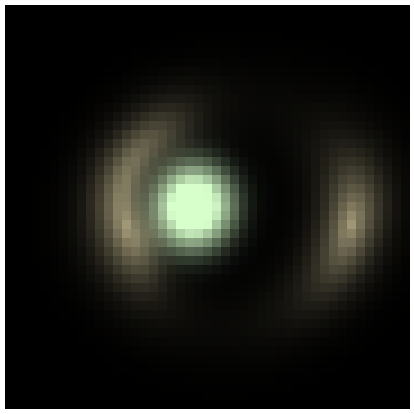

In [4]:
image_b = f106_lens.get_array(51, 5.61)
image_g = f129_lens.get_array(51, 5.61)
image_r = f184_lens.get_array(51, 5.61)

rgb_synthetic_image = color.get_rgb(image_b, image_g, image_r, minimum=None, stretch=3, Q=4)
rgb_synthetic_image = util.center_crop_image(rgb_synthetic_image, (45, 45))

plt.imshow(rgb_synthetic_image)
plt.axis('off')
plt.show()

# Generate Pandeia images for each band

In [5]:
bands = ['f106', 'f129', 'f184']
arrays = [image_b, image_g, image_r]
lenses = [f106_lens, f129_lens, f184_lens]
pandeia_images = []

for i, array in enumerate(arrays):
    calc, _ = pandeia_input.build_pandeia_calc(array, lenses[i], background=True, band='f106', max_scene_size=5, noise=True, num_samples=10000,
                       suppress_output=False)
    image, _ = pandeia_input.get_pandeia_image(calc, suppress_output=False)
    pandeia_images.append(image)

  2%|▏         | 18/903 [00:00<00:04, 177.89it/s]

100%|██████████| 903/903 [00:05<00:00, 168.77it/s]


Point source conversion complete: placed 903 point sources
Estimated calculation time: 0:01:11
Performing Pandeia calculation...
Pandeia calculation complete in 0:01:03


100%|██████████| 865/865 [00:05<00:00, 171.65it/s]


Point source conversion complete: placed 865 point sources
Estimated calculation time: 0:01:08
Performing Pandeia calculation...
Pandeia calculation complete in 0:01:00


100%|██████████| 928/928 [00:05<00:00, 170.84it/s]


Point source conversion complete: placed 928 point sources
Estimated calculation time: 0:01:13
Performing Pandeia calculation...
Pandeia calculation complete in 0:01:05


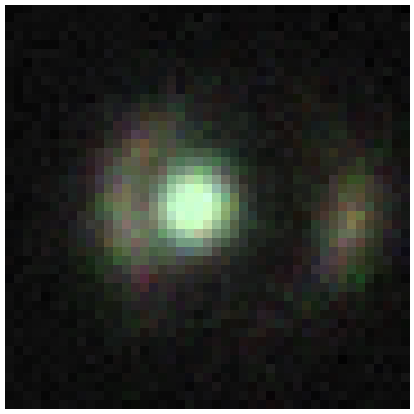

In [6]:
pandeia_rgb_image = color.get_rgb(pandeia_images[0], pandeia_images[1], pandeia_images[2], minimum=None, stretch=3, Q=4)

plt.imshow(pandeia_rgb_image)
plt.axis('off')
plt.show()

Compare the "synthetic" `lenstronomy` image (left) with the Pandeia simulation (right).

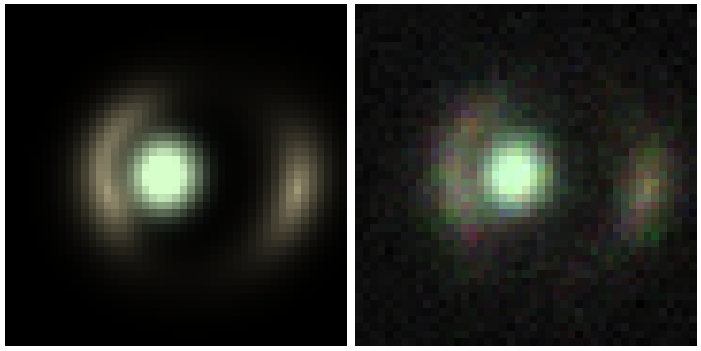

In [7]:
f, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

ax[0].imshow(rgb_synthetic_image)
ax[1].imshow(pandeia_rgb_image)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.show()